# Image Processing and Feature Extraction

In this step, we will process the images and then extract new features from them. Our technique will consist of two steps:

1 - **Pre-process the images:** First, since the images have rotation symmetry, let's find the rotation angle, with the help of OpenCV, and undo the rotation, so similar images will be approximately aligned. The second processing step will be to find the region of interest in the images, since most images are made up of empty pixels with no information. With that, after that, we will put all the cropped images to the same standard size to enter the transformer.


2 - **Create new features:** When you open the images, you can see different brightness patterns. Some images have three points of greater intensity, others only two, while some others have four. Finding the number of these points of greater luminosity, as well as their intensity and location in relation to the others, can be important features. On the other hand, the simulation area can also be an important measure. So, let's get these values ​​for the images and put them to be processed in the Transformer.

# Importing libraries

In [ ]:
import os
import cv2
import glob
import math
import numpy as np
from typing import Tuple
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Open the data:

In [ ]:
X_train_path = os.path.join('..','..','data','splitted','images','X_train.npy')
y_train_path = os.path.join('..','..','data','splitted','labels','y_train.npy')

Opening:

In [ ]:
X_train = np.load(X_train_path)['data']
y_train = np.load(y_train_path)['label']

# Pre-process

Let's take one image of the dataset to operate:

In [ ]:
image = X_train[2]

Let's visualize:

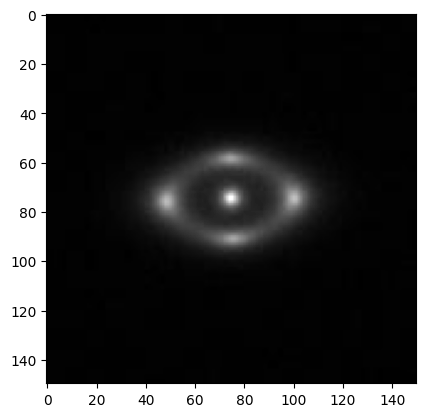

In [ ]:
plt.imshow(image,cmap='gray')
plt.show()

Let's apply Gaussian blur with kernel size:

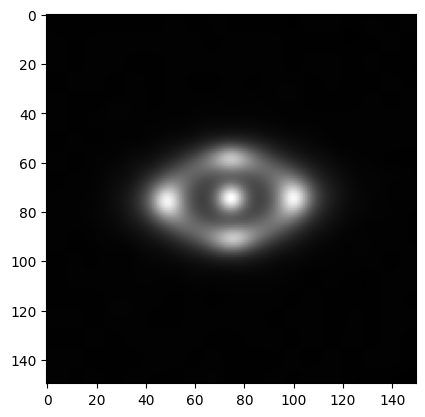

In [ ]:
blurred_image = cv2.GaussianBlur(image, (15, 15), 0)
plt.imshow(blurred_image,cmap='gray')
plt.show()

Threshold the blurred image using a value of 0.02. Pixels with values less than or equal to 0.02 will be set to 0, and pixels with values greater than 0.02 will be set to 1:

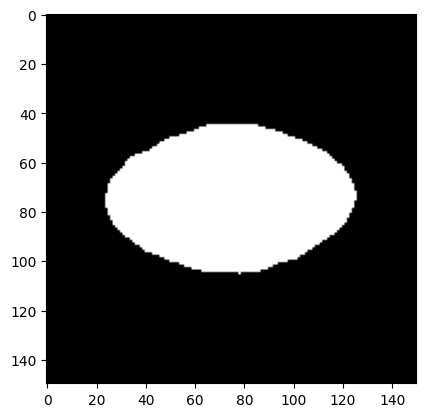

In [ ]:
_, binary_image = cv2.threshold(blurred_image, 0.02, 1, cv2.THRESH_BINARY)
plt.imshow(binary_image,cmap='gray')
plt.show()

Creating a structuring element for morphological operations:

In [ ]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))

Applying morphological opening operation to remove small objects from the binary image:

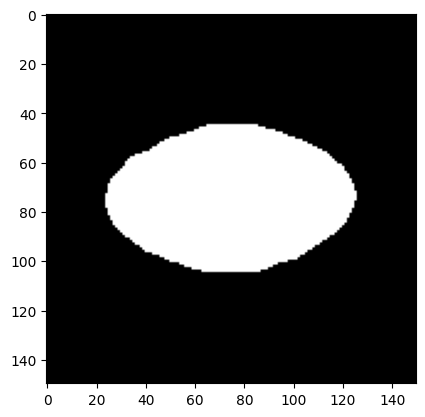

In [ ]:
opening_image = cv2.morphologyEx(binary_image, cv2.MORPH_OPEN, kernel)
plt.imshow(opening_image,cmap='gray')
plt.show()

Finding contours in the opening image using RETR_TREE retrieval mode and CHAIN_APPROX_NONE approximation method:

In [ ]:
contours, _ = cv2.findContours(image=cv2.convertScaleAbs(opening_image),
                               mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)

Now we found the contours of the last image, let's create a function to crop the minimum area rectangle and to rotate it:

In [ ]:
def crop_min_area_rectangle(image, contour, final_size):

  # Find minimum area rectangle for the given contour
  min_area_rect = cv2.minAreaRect(contour)

  # Convert rectangle to box points and then to integers
  box_points = cv2.boxPoints(min_area_rect)
  box_points = np.int0(box_points)

  # Extract width and height of rectangle
  width = min_area_rect[1][0]
  height = min_area_rect[1][1]

  # Find the minimum and maximum x and y coordinates of the box points
  x_coordinates = [point[0] for point in box_points]
  y_coordinates = [point[1] for point in box_points]
  x1 = min(x_coordinates)
  x2 = max(x_coordinates)
  y1 = min(y_coordinates)
  y2 = max(y_coordinates)

  # Adjust the angle if necessary to be within the range [-45, 45]
  angle = min_area_rect[2]
  if angle < -45:
      angle += 90

  # Calculate the center and size of the upright rectangle bounding the rotated rectangle
  center = ((x1+x2)/2, (y1+y2)/2)
  size = (x2-x1, y2-y1)

  # Get the transformation matrix for rotating the image
  rotation_matrix = cv2.getRotationMatrix2D((size[0]/2, size[1]/2), angle, 1.0)

  # Crop the upright rectangle
  cropped_rectangle = cv2.getRectSubPix(cv2.convertScaleAbs(255*image.copy()), size, center)

  # Rotate the cropped rectangle
  cropped_rectangle = cv2.warpAffine(cropped_rectangle, rotation_matrix, size)

  # Determine the width and height of the final cropped and rotated rectangle
  cropped_width = height if height > width else width
  cropped_height = height if height < width else width

  # Get the final cropped and rotated rectangle
  cropped_rotated = cv2.getRectSubPix(cropped_rectangle, (int(cropped_height), int(cropped_width)), (size[0]/2, size[1]/2))

  # Normalize the pixel values to be in the range [0, 1]
  cropped_rotated = cropped_rotated/255

  # Resize the image to the desired final size
  cropped_rotated = cv2.resize(cropped_rotated, final_size, interpolation=cv2.INTER_CUBIC)

  return cropped_rotated

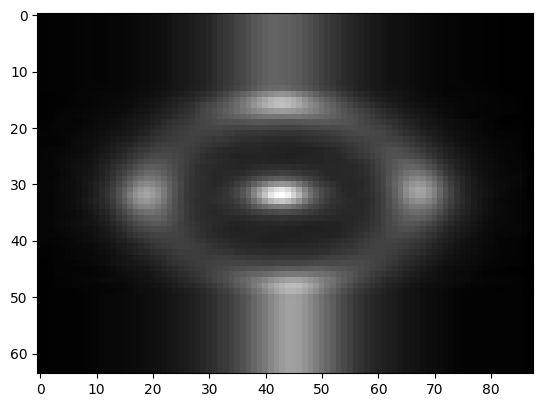

In [ ]:
cropped_rotated_image = crop_min_area_rectangle(image, contours[0],final_size=(88,64))
plt.imshow(cropped_rotated_image,cmap='gray')
plt.show()

The original photo has been transformed into the displayed photo, which has a view of the area of ​​interest in the image and removes rotational symmetry, so rotated photos that represent the same image are brought into (or close to) the original image.

# Creation of new features

## Area


Let's find the area of the region of interest in image:

In [ ]:
# Calculate percentage of area of contours in original image
original_size = (150,150)
percentual_area = cv2.contourArea(contours[0]) / (original_size[0] * original_size[1])
print(f'The percentual_area is: {percentual_area:0.2f}% of the original image')

The percentual_area is: 0.15% of the original image


## Number of areas of greater light intensity

When you see the image, you can verify that it have some more intensity points.

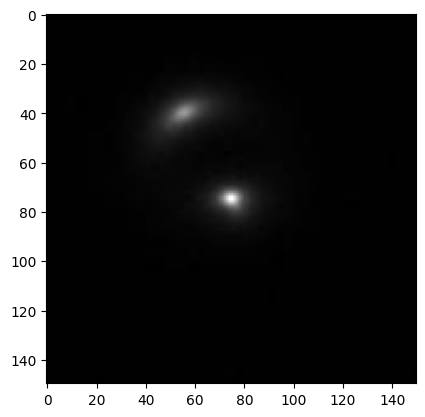

In [ ]:
plt.imshow(image,cmap='gray')
plt.show()

Let's count the number of them:

Threshold blurred image at certain level and get number of objects:

In [ ]:
blurred = cv2.GaussianBlur(image, (5, 5), 0)

Let's define the level of threshold for the intensity:

In [ ]:
intensity_level = 0.35

Threshold for level:

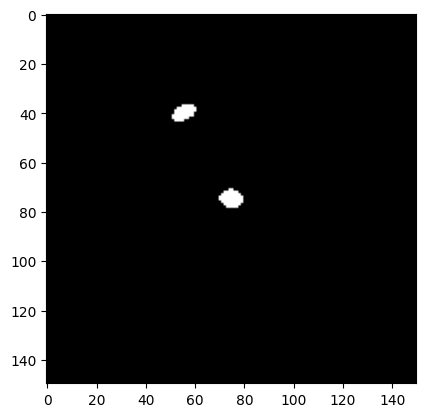

In [ ]:
# Threshold for very low level
_, level_image = cv2.threshold(blurred, intensity_level, 1, cv2.THRESH_BINARY)
plt.imshow(level_image,cmap='gray')
plt.show()

Then, to find the number, its just to count the number of contours:

In [ ]:
contours, _ = cv2.findContours(image=cv2.convertScaleAbs(level_image), mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)
num_obj_level = len(contours)
print(f'The number of objects is {num_obj_level}')

The number of objects is 2


## Distance of areas of greater light intensity

To find the maximum and mininum distance between them is just to calculate the distances between them and take the maximum and minimum:

In [ ]:
def get_dmax_dmin(contours):
  # check if there are more than one contour
  if len(contours)>1:
    # create empty lists to store the centers and distances
    centers = []
    distances = []
    # iterate over each contour
    for c in contours:
      # compute the center of the contour
      M = cv2.moments(c)
      if M["m00"]>0:
        cX = int(M["m10"] / (M["m00"]))
        cY = int(M["m01"] / (M["m00"]))
      else:
        # if the area is 0, set the center to (0,0)
        cX = int(M["m10"] / (1))
        cY = int(M["m01"] / (1))
      # append the center to the list of centers
      centers.append((cX,cY))
    # iterate over each pair of centers
    for i in range(len(contours)-1):
      for j in range(i+1,len(contours)):
          # compute the distance between the two centers
          d = math.dist(centers[i],centers[j])
          # append the distance to the list of distances
          distances.append(d)
    # compute the minimum and maximum distances
    dmin = int(min(distances))
    dmax = int(max(distances))
    return dmax,dmin
  else:
    # if there is only one contour, return -1,-1 as an indication that dmax and dmin are undefined
    return -1,-1

In [ ]:
contours, _ = cv2.findContours(image=cv2.convertScaleAbs(level_image), mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)
dmax_level, dmin_level = get_dmax_dmin(contours)
print(f'The maximum distance between the objects is {dmax_level} (diagonal of image rotated image is 109)')

The maximum distance between the objects is 39 (diagonal of image rotated image is 109)


# Putting it all together

Once we have different levels of intensity, we're going to use 4 different levels for the intensity, to try to capture more features.

In [ ]:
def get_features(image, final_image_size: Tuple = (88,64), very_low_level: int = 0.1,
                 low_level: int = 0.3, medium_level: int = 0.35, high_level: int = 0.4,
                 original_size: int = 150):

    # Preprocessing steps
    blurred = cv2.GaussianBlur(image, (15, 15), 0)
    _, thresh = cv2.threshold(blurred, 0.02, 1, cv2.THRESH_BINARY)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)

    # Get contours from opening image
    contours, _ = cv2.findContours(image=cv2.convertScaleAbs(opening), mode=cv2.RETR_TREE,
                                    method=cv2.CHAIN_APPROX_NONE)

    # Crop image to minimum area rectangle and resize to desired final image size
    final_image = crop_min_area_rectangle(image, contours[0], final_image_size)

    # Calculate percentage of area of contours in original image
    percentual_area = cv2.contourArea(contours[0]) / (original_size * original_size)

    # Threshold blurred image at different levels and get number of objects and dmax/dmin for each
    blurred = cv2.GaussianBlur(image, (5, 5), 0)

    # Threshold for very low level
    _, very_low_level_image = cv2.threshold(blurred, very_low_level, 1, cv2.THRESH_BINARY)
    # Find contours for very low level
    contours, _ = cv2.findContours(image=cv2.convertScaleAbs(very_low_level_image), mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)
    # Calculate number of objects and max and min diameters for very low level
    num_obj_very_low_level = len(contours)
    dmax_very_low, dmin_very_low = get_dmax_dmin(contours)

    # Threshold for low level
    _, low_level_image = cv2.threshold(blurred, low_level, 1, cv2.THRESH_BINARY)
    # Find contours for low level
    contours, _ = cv2.findContours(image=cv2.convertScaleAbs(low_level_image), mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)
    # Calculate number of objects and max and min diameters for low level
    num_obj_low_level = len(contours)
    dmax_low, dmin_low = get_dmax_dmin(contours)

    # Threshold for medium level
    _, medium_level_image = cv2.threshold(blurred, medium_level, 1, cv2.THRESH_BINARY)
    # Find contours for medium level
    contours, _ = cv2.findContours(image=cv2.convertScaleAbs(medium_level_image), mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)
    # Calculate number of objects and max and min diameters for medium level
    num_obj_medium_level = len(contours)
    dmax_medium, dmin_medium = get_dmax_dmin(contours)

    # Threshold for high level
    _, high_level_image = cv2.threshold(blurred, high_level, 1, cv2.THRESH_BINARY)
    # Find contours for high level
    contours, _ = cv2.findContours(image=cv2.convertScaleAbs(high_level_image), mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)
    # Calculate number of objects and max and min diameters for high level
    num_obj_high_level = len(contours)
    dmax_high, dmin_high = get_dmax_dmin(contours)

    # Calculate the maximum and minimum distance between contours for each level
    dmax = np.array([dmax_very_low, dmax_low, dmax_medium, dmax_high])
    dmin = np.array([dmin_very_low, dmin_low, dmin_medium, dmin_high])
    num_obj = np.array([num_obj_low_level, num_obj_low_level, num_obj_medium_level, num_obj_high_level])

    # normalize the arrays
    dmax = dmax / math.dist(final_image_size, (0,0))
    dmin = dmin / math.dist(final_image_size, (0,0))
    num_obj = (num_obj - 3) / 3

    # Return all calculated features as a tuple
    return final_image,percentual_area,dmax,dmin,num_obj

In [ ]:
final_image,percentual_area,dmax,dmin,num_obj = get_features(image)

## The final features are:

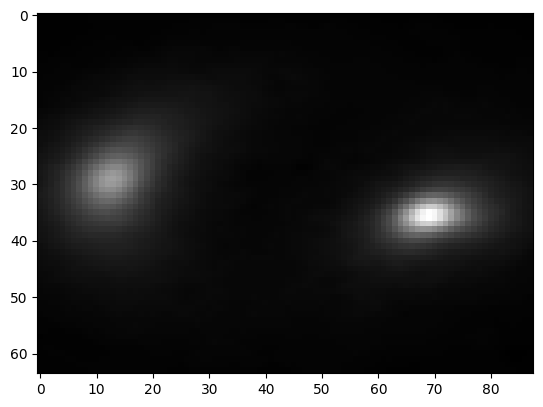

In [ ]:
plt.imshow(final_image,cmap='gray')
plt.show()

In [ ]:
percentual_area

0.15484444444444445

In [ ]:
dmax

array([0.35841713, 0.35841713, 0.35841713, 0.35841713])

In [ ]:
dmin

array([0.35841713, 0.35841713, 0.35841713, 0.35841713])

In [ ]:
num_obj

array([-0.33333333, -0.33333333, -0.33333333, -0.33333333])